<a href="https://colab.research.google.com/github/haritraman/phishing_url/blob/main/cyber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1 - Imports & seed
import os, random, re, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from urllib.parse import urlparse

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Mount Drive (Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

print("✅ Imports, seed and Drive mount done.")


Mounted at /content/drive
✅ Imports, seed and Drive mount done.


In [ ]:
# Cell 2 - Load CSVs and extract a 'url' column from each (robust to different column names)

def extract_url_series(df, source_name):
    # Try likely column names in order
    candidates = ['url', 'URL', 'Url', 'domain', 'Domain', 'DomainName', 'Host', 'host', 'link', 'Link']
    for c in candidates:
        if c in df.columns:
            s = df[c].astype(str).str.strip()
            # If column is a domain (no scheme), prepend http:// for parsing consistency
            s = s.apply(lambda u: u if u.lower().startswith(('http://','https://')) else 'http://' + u if u != '' else '')
            return s
    # Fallback: try first column
    first_col = df.columns[0]
    s = df[first_col].astype(str).str.strip()
    s = s.apply(lambda u: u if u.lower().startswith(('http://','https://')) else 'http://' + u if u != '' else '')
    return s

# Update paths if needed
majestic_path = "/content/drive/My Drive/majestic_million.csv"
verified_path = "/content/drive/My Drive/verified_online.csv"

df_majestic = pd.read_csv(majestic_path, low_memory=False)
df_verified = pd.read_csv(verified_path, low_memory=False)

# Extract urls
urls_majestic = extract_url_series(df_majestic, 'majestic')
urls_verified = extract_url_series(df_verified, 'verified')

print("Majestic sample:", urls_majestic.iloc[:3].tolist())
print("Verified sample:", urls_verified.iloc[:3].tolist())
print("Counts -> majestic:", len(urls_majestic), "verified:", len(urls_verified))


Majestic sample: ['http://google.com', 'http://facebook.com', 'http://youtube.com']
Verified sample: ['https://revenue.payipo.cc/notice', 'https://pay.pag-club.site/P5LNZ8zOzndgaRy', 'https://swtreasurymanager.de/ui/index.php']
Counts -> majestic: 1000000 verified: 50810


In [ ]:
# Cell 3 - Combine, label, dedupe, sample to balance

# Assume: verified_online = phishing (label=1), majestic = benign (label=0)
malicious_urls = pd.Series(urls_verified.unique()).dropna().astype(str).str.strip()
benign_urls    = pd.Series(urls_majestic.unique()).dropna().astype(str).str.strip()

# Remove empty strings
malicious_urls = malicious_urls[malicious_urls != '']
benign_urls = benign_urls[benign_urls != '']

# Ensure no accidental overlap
intersection = set(malicious_urls) & set(benign_urls)
print("Intersection (same URL in both sources):", len(intersection))
if len(intersection) > 0:
    print("Example overlaps:", list(intersection)[:5])
    # Remove overlapping entries from benign (or malicious) -- we drop them from benign here:
    benign_urls = [u for u in benign_urls if u not in intersection]

# Balanced sampling (choose minimum size or limit)
max_sample = 50000  # <= adjust as you want
n = min(max_sample, len(malicious_urls), len(benign_urls))
print("Using sample size per class:", n)

mal_sample = np.random.choice(malicious_urls, n, replace=False)
ben_sample = np.random.choice(benign_urls, n, replace=False)

df_mal = pd.DataFrame({'url': mal_sample, 'label': 1, 'source': 'verified_online'})
df_ben = pd.DataFrame({'url': ben_sample, 'label': 0, 'source': 'majestic_million'})

df = pd.concat([df_mal, df_ben], ignore_index=True).sample(frac=1, random_state=seed).reset_index(drop=True)

print("Combined df shape:", df.shape)
print(df['label'].value_counts())
print("Some example rows:\n", df.head())


Intersection (same URL in both sources): 3
Example overlaps: ['http://easyhotel.com.my', 'http://builderallwppro.com', 'http://web66.com.tw']
Using sample size per class: 50000
Combined df shape: (100000, 3)
label
0    50000
1    50000
Name: count, dtype: int64
Some example rows:
                                                  url  label            source
0                              http://africafoot.com      0  majestic_million
1                               http://cialishav.com      0  majestic_million
2  https://docs.google.com/presentation/d/e/2PACX...      1   verified_online
3                        http://edinburghbicycle.com      0  majestic_million
4                          http://shinmicatering.com      0  majestic_million


In [ ]:
# Cell 4 - Preprocess and comprehensive feature extractor (robust)

def preprocess_urls(urls, keep_scheme=True):
    processed = []
    for url in urls:
        try:
            u = str(url).strip()
            if u == '':
                processed.append('')
                continue
            u = u.lower()
            if not keep_scheme:
                u = re.sub(r'^https?://', '', u)
            u = re.sub(r'^www\.', '', u)
            u = re.sub(r'\s+', '', u)
            processed.append(u)
        except:
            processed.append('')
    return processed

def extract_advanced_features(urls):
    features = []
    for url in urls:
        try:
            # Ensure parseable
            if not url.lower().startswith(('http://','https://')):
                parse_url = 'http://' + url
            else:
                parse_url = url

            parsed = urlparse(parse_url)

            url_str = url
            url_length = len(url_str)
            domain = parsed.netloc or ''
            path = parsed.path or ''
            num_dots = url_str.count('.')
            num_hyphens = url_str.count('-')
            num_slashes = url_str.count('/')
            num_question_marks = url_str.count('?')
            num_equals = url_str.count('=')
            num_ampersands = url_str.count('&')
            num_digits = sum(c.isdigit() for c in url_str)
            num_special_chars = len(re.findall(r'[^a-zA-Z0-9\.\/\-\:]', url_str))

            has_https = 1 if parsed.scheme == 'https' else 0
            has_ip = 1 if re.match(r'^\d+\.\d+\.\d+\.\d+$', domain) else 0
            has_at_symbol = 1 if '@' in url_str else 0
            has_redirect = 1 if '//' in path else 0

            shorteners = ['bit.ly','goo.gl','tinyurl','t.co','ow.ly','is.gd','buff.ly']
            has_shortener = 1 if any(s in domain for s in shorteners) else 0

            domain_parts = domain.split('.') if domain else []
            num_subdomains = max(0, len(domain_parts) - 2)

            tld = domain_parts[-1] if domain_parts else ''
            suspicious_tlds = set(['xyz','top','club','online','tk','ml','ga','cf','gq','pw'])
            suspicious_tld = 1 if tld in suspicious_tlds else 0

            suspicious_keywords = ['login','verify','secure','account','bank','update','signin','password','wallet','payment','confirm','free','gift','prize','claim','reward','click','security','alert','urgent','phish','scam']
            num_suspicious_keywords = sum(1 for kw in suspicious_keywords if kw in url_str)

            # entropy
            if len(url_str) > 0:
                entropy = -sum((url_str.count(c) / len(url_str)) * np.log2(url_str.count(c) / len(url_str)) for c in set(url_str) if url_str.count(c)>0)
            else:
                entropy = 0

            vowel_count = sum(1 for c in url_str if c in 'aeiou')
            vowel_ratio = vowel_count / len(url_str) if len(url_str)>0 else 0

            features.append([
                url_length, len(domain), len(path), num_dots, num_hyphens, num_slashes,
                num_question_marks, num_equals, num_ampersands, num_digits, num_special_chars,
                has_https, has_ip, has_at_symbol, has_redirect, has_shortener, num_subdomains,
                suspicious_tld, num_suspicious_keywords, entropy, vowel_ratio
            ])
        except Exception as e:
            features.append([0]*21)
    cols = [
        'url_length','domain_length','path_length','num_dots','num_hyphens','num_slashes',
        'num_question_marks','num_equals','num_ampersands','num_digits','num_special_chars',
        'has_https','has_ip','has_at_symbol','has_redirect','has_shortener','num_subdomains',
        'suspicious_tld','num_suspicious_keywords','entropy','vowel_ratio'
    ]
    return np.array(features), cols

# Create processed urls and features
df['url'] = df['url'].astype(str)  # ensure str
processed_urls = preprocess_urls(df['url'].values, keep_scheme=True)  # keep scheme for feature extraction
X_features, feature_names = extract_advanced_features(processed_urls)
y = df['label'].values

print("Processed examples:", processed_urls[:3])
print("Feature matrix shape:", X_features.shape)


Processed examples: ['http://africafoot.com', 'http://cialishav.com', 'https://docs.google.com/presentation/d/e/2pacx-1vr26vj9dqeau7kro4re0v51pmefyg6m7km-ubzmyk-xnnaumd8vx6oq_hb1_gs7h_6muoiok8y8jqus/pub?start=false&loop=false&delayms=3000&slide=id.p']
Feature matrix shape: (100000, 21)


In [ ]:
# Cell 5 - Sanity checks
print("Total rows:", len(df))
print("Duplicates (same url):", df['url'].duplicated().sum())

# Confirm class balance after sampling
print("Label counts:\n", df['label'].value_counts())

# If you want to see if any url repeated across classes (should be 0)
mal_set = set(df[df['label']==1]['url'])
ben_set = set(df[df['label']==0]['url'])
print("Intersection between classes:", len(mal_set & ben_set))


Total rows: 100000
Duplicates (same url): 0
Label counts:
 label
0    50000
1    50000
Name: count, dtype: int64
Intersection between classes: 0


Starting Feature Importance Analysis on all 21 features...
Preliminary Random Forest trained on 21 features.

Feature Importances (Top 10 of 21 Features):
path_length       0.301485
num_slashes       0.238903
has_https         0.179906
num_dots          0.072472
url_length        0.070058
num_digits        0.033325
num_subdomains    0.029583
entropy           0.027978
domain_length     0.021423
num_hyphens       0.010497
dtype: float64


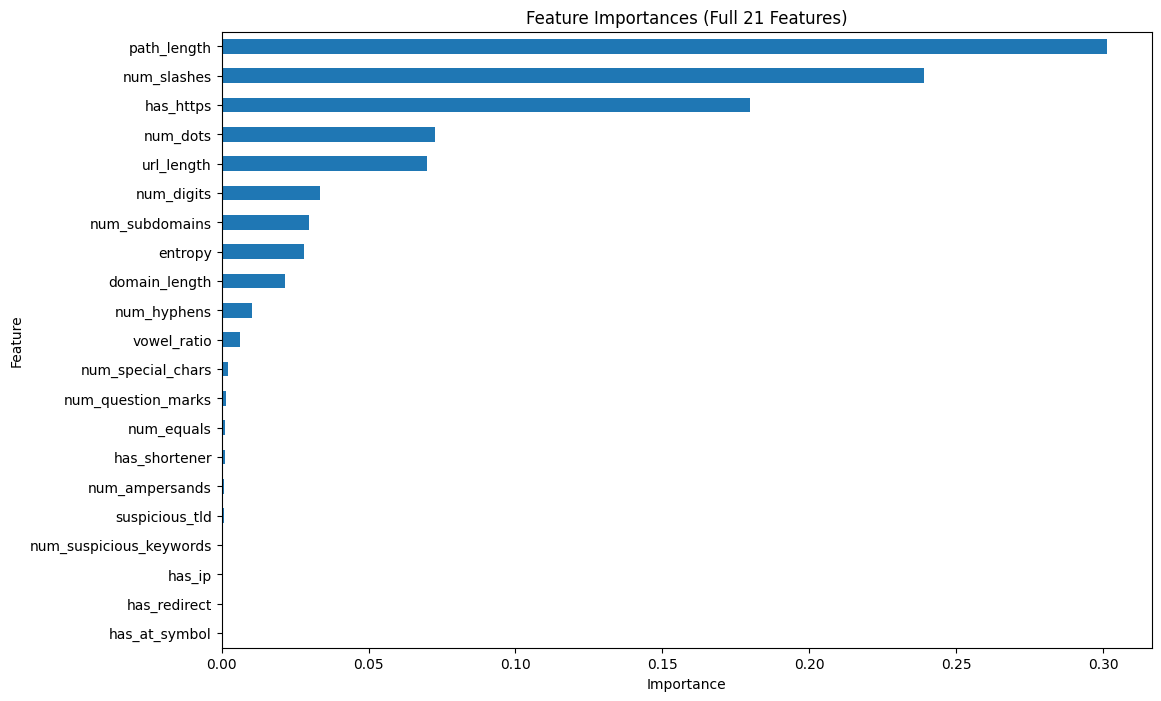


Confirmed/Suggested Top 5 Features for Final Model Training:
['path_length', 'num_slashes', 'has_https', 'num_dots', 'url_length']


In [ ]:
# New Cell - Feature Importance Analysis (To be placed before Cell 6)
### Feature Importance Analysis for Full 21 Features

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("Starting Feature Importance Analysis on all 21 features...")

# 1. Split data (Full Features)
# Note: We must re-split and re-scale here because we are using ALL 21 features,
# and we need to fit the scaler to the full set of 21 features.
X_imp_train, X_imp_test, y_imp_train, y_imp_test = train_test_split(
    X_features, y, test_size=0.2, random_state=seed, stratify=y
)

# 2. Scale Features (Crucial to fit scaler on 21 features)
scaler_imp = StandardScaler()
X_imp_train_scaled = scaler_imp.fit_transform(X_imp_train)
# We don't need to transform the test set for feature importance, but we can.
# X_imp_test_scaled = scaler_imp.transform(X_imp_test)

# 3. Train a Preliminary Random Forest Model (using all 21 features)
# Random Forest is a great choice for this task as it handles non-linear relationships
# and provides intrinsic feature importances.
rf_importance_model = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
rf_importance_model.fit(X_imp_train_scaled, y_imp_train)
print("Preliminary Random Forest trained on 21 features.")

# 4. Get and Display Feature Importances
importances = rf_importance_model.feature_importances_

# Create a Series for easy sorting and plotting
feature_importance_series = pd.Series(importances, index=feature_names)

# Sort the features by importance
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

print("\nFeature Importances (Top 10 of 21 Features):")
print(sorted_feature_importances.head(10))

# 5. Plot the Feature Importances
plt.figure(figsize=(12, 8))
sorted_feature_importances.plot(kind='barh')
plt.title('Feature Importances (Full 21 Features)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Display most important at the top
plt.show()

# 6. Select the actual top 5 features based on this analysis
# This confirms or corrects the list used in Cell 6
# NOTE: The list 'top_5_features' in Cell 6 must be updated if this analysis yields a different set.
new_top_5_features = sorted_feature_importances.head(5).index.tolist()
print("\nConfirmed/Suggested Top 5 Features for Final Model Training:")
print(new_top_5_features)

# The existing Cell 6 uses: top_5_features = ['path_length', 'num_slashes', 'has_https', 'num_dots', 'url_length']
# You would need to manually update the 'top_5_features' list in Cell 6 if the output above differs.

In [ ]:
# Cell 6 - Split first and Scale Features

# Define the top 5 features based on the previous analysis
top_5_features = ['path_length', 'num_slashes', 'has_https', 'num_dots', 'url_length']

# Select only the top 5 features from the feature matrix
X_features_top5 = X_features[:, [feature_names.index(f) for f in top_5_features]]

# Split data using the reduced feature set
urls_train, urls_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    processed_urls, X_features_top5, y, test_size=0.2, random_state=seed, stratify=y
)

print("Train samples:", len(urls_train), "Test samples:", len(urls_test))

# Scaler - fit on train only
scaler = StandardScaler()
X_feat_train_scaled = scaler.fit_transform(X_feat_train)
X_feat_test_scaled = scaler.transform(X_feat_test)




print("X_feat_train shape:", X_feat_train_scaled.shape)

Train samples: 80000 Test samples: 20000
X_feat_train shape: (80000, 5)


In [ ]:
# Cell 7 - Model (Random Forest)
from sklearn.ensemble import RandomForestClassifier

# For Random Forest, we don't need the complex Keras model structure.
# The features are already scaled and ready to be used directly.

print("Using Random Forest Classifier.")
# model definition is no longer needed in this cell

Using Random Forest Classifier.


In [ ]:
# Cell 8 - Train (Random Forest)

# For Random Forest, we don't use Keras callbacks like EarlyStopping, ReduceLROnPlateau, ModelCheckpoint.
# Training is a single call to the fit method.

# Initialize and train the Random Forest model
# You might want to tune parameters like n_estimators, max_depth, etc.
model = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)

print("Training Random Forest model with top 5 features...")
model.fit(X_feat_train_scaled, y_train)
print("Training complete.")

# Note: For Random Forest, saving and loading is done using pickle
# This will be handled in a later cell (Cell 11).

Training Random Forest model with top 5 features...
Training complete.


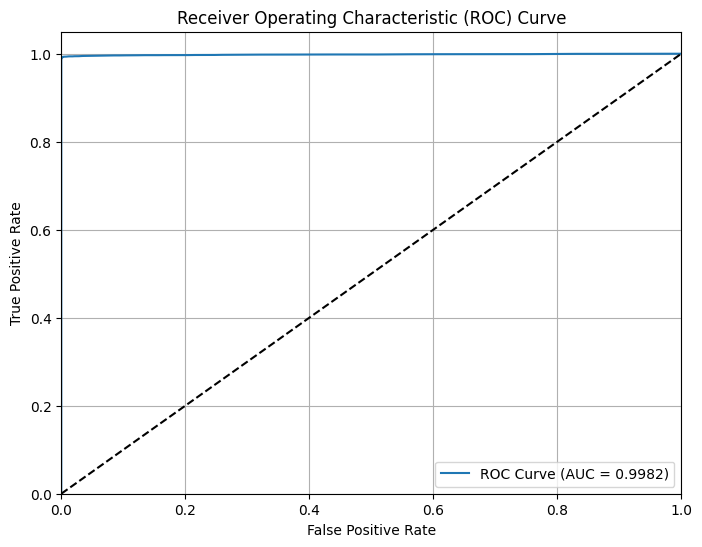

In [ ]:
# Generate ROC curve
from sklearn.metrics import roc_curve, RocCurveDisplay

y_pred_proba = model.predict_proba(X_feat_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], 'k--') # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Cell 10 - Evaluation (use probabilities for AUC)
y_pred_proba = model.predict_proba(X_feat_test_scaled)[:, 1] # Get probability for the positive class
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC (probabilities):", roc_auc_score(y_test, y_pred_proba))

Classification Report:
               precision    recall  f1-score   support

           0     0.9925    0.9980    0.9953     10000
           1     0.9980    0.9925    0.9952     10000

    accuracy                         0.9952     20000
   macro avg     0.9953    0.9952    0.9952     20000
weighted avg     0.9953    0.9952    0.9952     20000

Confusion Matrix:
 [[9980   20]
 [  75 9925]]
ROC AUC (probabilities): 0.99816496


In [ ]:
# Cell 11 - save preprocessing
with open('scaler.pkl','wb') as f:
    pickle.dump(scaler, f)

# Save the Random Forest model using pickle
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Saved scaler and Random Forest model.")

Saved scaler and Random Forest model.


In [ ]:
# # Cell 12 - predict new URL (uses same preprocessing)

# # Define the top 5 features used for training
# top_5_features = ['path_length', 'num_slashes', 'has_https', 'num_dots', 'url_length']

# def predict_new_url(url, model, scaler, threshold=0.5): # Removed tokenizer from signature and default threshold changed to 0.5
#     u = url.strip()
#     if not u.lower().startswith(('http://','https://')):
#         u = 'http://' + u
#     processed = preprocess_urls([u], keep_scheme=True)[0]
#     # Text features (padded) are not used by the Random Forest model
#     # seq = tokenizer.texts_to_sequences([processed])
#     # padded = pad_sequences(seq, maxlen=max_len)

#     feats, all_feature_names = extract_advanced_features([processed])

#     # Select only the top 5 features for prediction
#     feats_top5 = feats[:, [all_feature_names.index(f) for f in top_5_features]]

#     # Display the top 5 feature values for the input URL
#     print("\nTop 5 Feature Values for this URL:")
#     for i, feature_name in enumerate(top_5_features):
#         print(f"  {feature_name}: {feats_top5[0, i]}")

#     scaled = scaler.transform(feats_top5)
#     # Random Forest predict_proba returns probabilities for each class
#     proba = model.predict_proba(scaled)[:, 1] # Get probability for the positive class
#     proba = proba[0] # Get the single probability value for the input url
#     label = "MALICIOUS" if proba >= threshold else "LEGIT"
#     print(f"\nURL: {url}\nProbability: {proba:.4f}\nLabel: {label}")
#     return proba, label

# # Example
# # Note: Ensure 'model' and 'scaler' are defined by running previous cells
# predict_new_url("https://www.microsoft.com/en-in/software-download/windows10", model, scaler) # Removed tokenizer argument